# Short Answer Questions

1. How many RDMs do we need to create?
    > We need to create an RDM for each class of subjects we want to compare. In this case, there are 7 ROIs and 2 feature sets (AlexNet and Word2Vec), so we need to create 9 RDMs in total.
2. How many total RSA correlations are possible?
    > RSAs are made from a combination of two RDMs, which is mathematically represented as "n choose 2". In this case, we have 9 RDMs, so the total number of possible RSA correlations is 9C2 = 36.
3. How many RSA correlations will you end up with?
    > Since we're only interested in comparing the 7 ROIs to the 2 feature sets, we will have 7 * 2 = 14 RSA correlations.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from load_neural_data import load_neural_data, get_roi_data

# Load all data
data = load_neural_data()

In [2]:
from load_feature_matrices import analyze_features

alexnet, word2vec = analyze_features()
# alexnet: (81, 20) - mean AlexNet features per category
# word2vec: (81, 30) - mean Word2Vec features per category

Feature Matrices
AlexNet:  (81, 20) (stimuli × features)
Word2Vec: (81, 30) (stimuli × features)


# 1. Calculate RDMs using Pearson distance

In [3]:
# Calculate the RDM given a data matrix
# The input should be a matrix of shape (n_categories, n_response)
# where the first dimension is the 81 categories and the 
# second dimension is the response of the ROI (number of voxels/features)
def calculate_rdm(response):
    n_cond = response.shape[0]
    assert n_cond == len(data['conds']), "Response matrix must have the proper number of conditions"

    rdm = np.zeros((n_cond, n_cond))
    for i in range(n_cond):
        for j in range(n_cond):
            rdm[i, j] = 1 - stats.pearsonr(response[i, :], response[j, :]).statistic

    return rdm

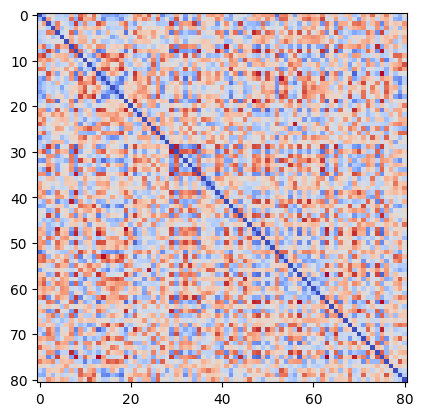

In [4]:
rdm = calculate_rdm(get_roi_data(data, 'FFA'))
plt.imshow(rdm, cmap='coolwarm', interpolation='nearest')

In [5]:
# For each of our ROIs, calculate the RDM
roi_rdms = {
    roi.item(): calculate_rdm(get_roi_data(data, roi.item())) for roi in data['rois'][0]
}

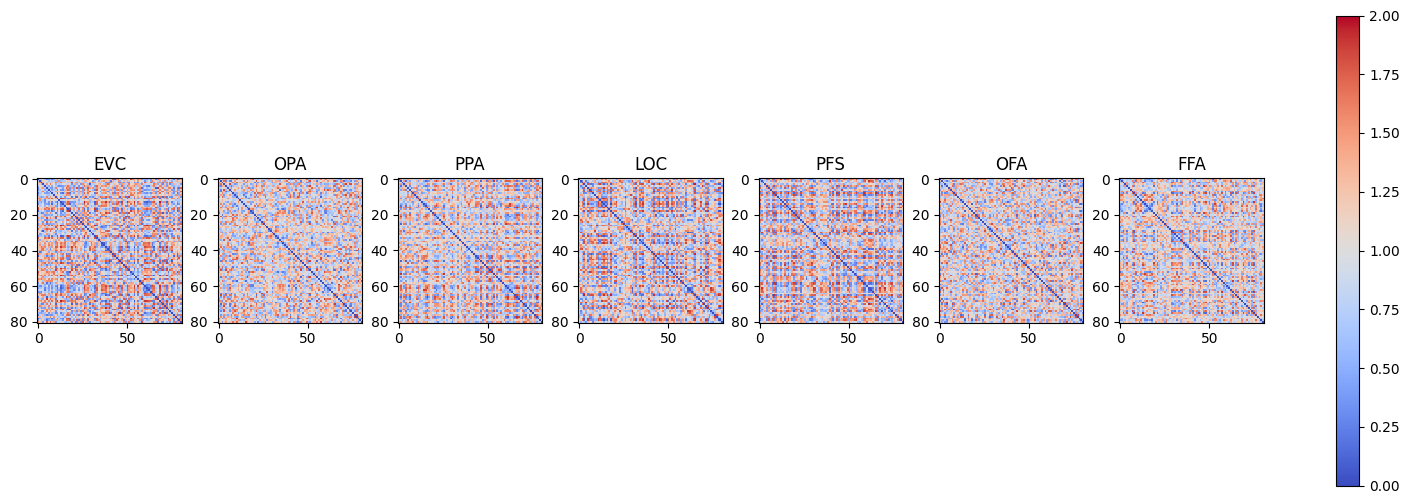

In [6]:
# Plot the RDMs for each ROI
fig, axes = plt.subplots(1, len(roi_rdms), figsize=(15, 5))

# Use the same color scale for all RDMs
vmin = 0 # min(rdm.min() for rdm in roi_rdms.values())
vmax = 2 # max(rdm.max() for rdm in roi_rdms.values())

for ax, (roi, rdm) in zip(axes, roi_rdms.items()):
    ax.imshow(rdm, cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
    ax.set_title(roi)
    
fig.tight_layout()

# Add a legend for the color scale
fig.colorbar(axes[0].images[0], ax=axes, orientation='vertical', fraction=.1)

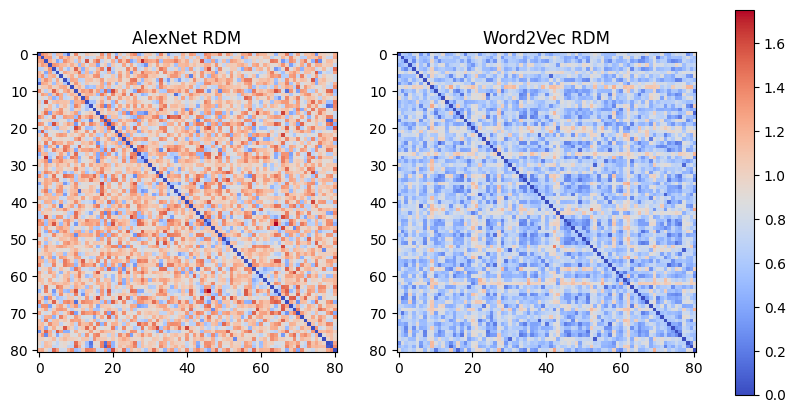

In [7]:
alex_rdm = calculate_rdm(alexnet)
word2vec_rdm = calculate_rdm(word2vec)

vmin = min(alex_rdm.min(), word2vec_rdm.min())
vmax = max(alex_rdm.max(), word2vec_rdm.max())

# Plot the feature RDMs
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(alex_rdm, cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
axes[0].set_title('AlexNet RDM')
axes[1].imshow(word2vec_rdm, cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)
axes[1].set_title('Word2Vec RDM')
    
# Add a legend for the color scale
fig.colorbar(axes[0].images[0], ax=axes, orientation='vertical', fraction=.1)

# 2. Compare RDMs using Spearman correlations

Question:  In our data, there are 81 stimulus conditions which produce a full
81x81 RDM. How many elements will the RDMs you compare have once we
account for the diagonal and duplicated data?

> The find the answer, we'll first consider removing the diagonal elements. Then, the upper and lower triangles have the same size, so we can just take one of them. This means the number of unique elements in the RDM is given by $\frac{n(n-1)}{2}$. In our case, that will be $\frac{81(81-1)}{2} = 3240$ unique elements.

In [8]:
def calculate_rsa(rdm1, rdm2):
    # Make sure both RDMs are square and of the same size
    assert rdm1.shape == rdm2.shape, "RDMs must be of the same shape"

    # Flatten the lower triangle of the RDMs (excluding the diagonal)
    mask = np.tril_indices(rdm1.shape[0], k=-1)
    vec1 = rdm1[mask]
    vec2 = rdm2[mask]
    
    # Compute the Spearman correlation between the two vectors
    return stats.spearmanr(vec1, vec2).statistic

assert calculate_rsa(roi_rdms['FFA'], roi_rdms['FFA']) == 1.0

# 3. Compare RSAs between ROIs and feature sets

C:\Users\kopal\AppData\Local\Temp\ipykernel_23288\2063391164.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(rsa_results['alexnet'].keys(), rotation=45)
C:\Users\kopal\AppData\Local\Temp\ipykernel_23288\2063391164.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(rsa_results['word2vec'].keys(), rotation=45)


[Text(0, 0, 'EVC'),
 Text(1, 0, 'OPA'),
 Text(2, 0, 'PPA'),
 Text(3, 0, 'LOC'),
 Text(4, 0, 'PFS'),
 Text(5, 0, 'OFA'),
 Text(6, 0, 'FFA')]

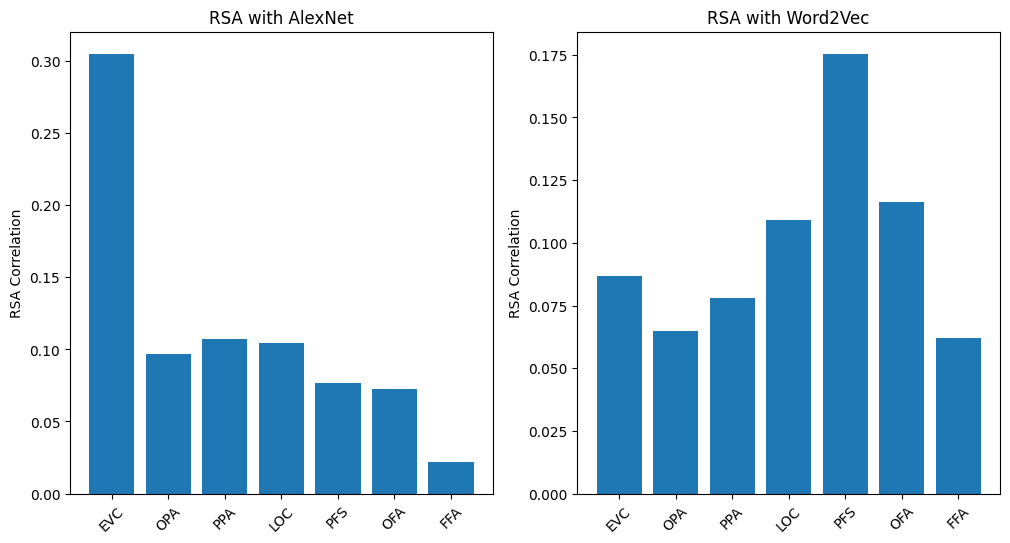

In [9]:
# Calculate the RSA correlations
rsa_results = {
    'word2vec': {
        roi: calculate_rsa(rdm, word2vec_rdm) for roi, rdm in roi_rdms.items()
    },
    'alexnet': {
        roi: calculate_rsa(rdm, alex_rdm) for roi, rdm in roi_rdms.items()
    },
}

# Plot the results on two adjacent bar charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].bar(rsa_results['alexnet'].keys(), rsa_results['alexnet'].values())
axes[0].set_title('RSA with AlexNet')
axes[0].set_ylabel('RSA Correlation')
axes[0].set_xticklabels(rsa_results['alexnet'].keys(), rotation=45)
axes[1].bar(rsa_results['word2vec'].keys(), rsa_results['word2vec'].values())
axes[1].set_title('RSA with Word2Vec') 
axes[1].set_ylabel('RSA Correlation')
axes[1].set_xticklabels(rsa_results['word2vec'].keys(), rotation=45)

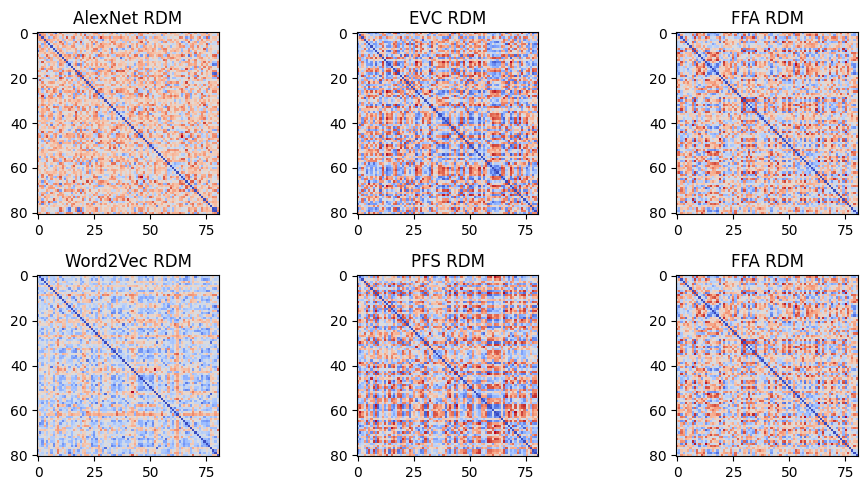

In [10]:
# Plot the highest correlations side by side
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
axes[0,0].imshow(alex_rdm, cmap='coolwarm', interpolation='nearest')
axes[0,0].set_title('AlexNet RDM')
axes[0,1].imshow(roi_rdms['EVC'], cmap='coolwarm', interpolation='nearest')
axes[0,1].set_title('EVC RDM')
axes[0,2].imshow(roi_rdms['FFA'], cmap='coolwarm', interpolation='nearest')
axes[0,2].set_title('FFA RDM')
axes[1,0].imshow(word2vec_rdm, cmap='coolwarm', interpolation='nearest')
axes[1,0].set_title('Word2Vec RDM')
axes[1,1].imshow(roi_rdms['PFS'], cmap='coolwarm', interpolation='nearest')
axes[1,1].set_title('PFS RDM')
axes[1,2].imshow(roi_rdms['FFA'], cmap='coolwarm', interpolation='nearest')
axes[1,2].set_title('FFA RDM')
plt.tight_layout()